In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast
import numpy as np
from scipy.special import softmax
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
#from datasets import load_dataset
#imdb = load_dataset("imdb")

In [16]:
#imdb['train']['text'][2]

"If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />"

---
### Load Data

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
train.head()

,train_idx,text,label,label_text
0,0,i really do recommend this to anyone in need o...,1,positive
1,1,very good every day camera fits nicely in the ...,1,positive
2,2,"but , dollar for dollar , this dvd player is p...",1,positive
3,3,i got this phone yesterday and didn ' t find a...,1,positive
4,4,1 ) price gb of storage,1,positive


In [5]:
train.isna().sum()

train_idx     0
text          0
label         0
label_text    0
dtype: int64

In [6]:
train.loc[1611]

train_idx                                                  1611
text          exposure compensation in 1 3 stop increments (...
label                                                         1
label_text                                             positive
Name: 1611, dtype: object

In [7]:
# show row 1611
print(train[train['train_idx'] == 1611].text.values[0])

exposure compensation in 1 3 stop increments ( i leave it set on 1 3 stop to brighten up the default exposure , which goes a bit dark for my taste )


In [8]:
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

<Axes: >

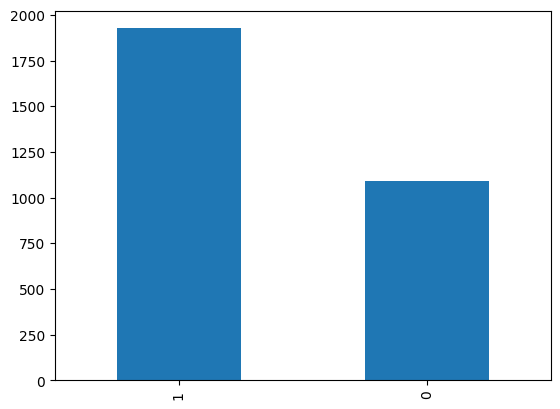

In [9]:
train['label'].value_counts().plot(kind='bar')

In [10]:
train['label_text'].value_counts()

positive    1926
negative    1090
Name: label_text, dtype: int64

In [11]:
# split the data into train and validation sets
from sklearn.model_selection import train_test_split
train_split, val_split = train_test_split(train, test_size=0.2, random_state=42)

In [12]:
train_split[train_split['train_idx'] == 1611]

,train_idx,text,label,label_text
1611,1611,exposure compensation in 1 3 stop increments (...,1,positive


#### Transform data to correct format

In [105]:
from torchtext.legacy import Field, TabularDataset, BucketIterator

ModuleNotFoundError: No module named 'torchtext.legacy'

In [107]:
# show contents of module torchtext.data
print(*(dir(torchtext.data)),sep='\n')

__all__
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
bleu_score
custom_replace
datasets_utils
filter_wikipedia_xml
functional
generate_sp_model
get_tokenizer
interleave_keys
load_sp_model
metrics
numericalize_tokens_from_iterator
sentencepiece_numericalizer
sentencepiece_tokenizer
simple_space_split
to_map_style_dataset
utils


In [113]:
set('this is a a test where words such as test are duplicated like this test'.split())

{'a',
 'are',
 'as',
 'duplicated',
 'is',
 'like',
 'such',
 'test',
 'this',
 'where',
 'words'}

---
### Load model

#### Using pytorch g

In [8]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.multiprocessing as mp

In [9]:
# NOTE: this device might need to be changed to 'cpu' if you're not using a GPU or apple silicon
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')

In [10]:
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

In [12]:
def tokenize(text):
    return tokenizer.encode_plus(text, 
                                  add_special_tokens=True, 
                                  padding=True, 
                                  return_attention_mask=True, 
                                  return_tensors='pt')

In [13]:
tokenize('test')

{'input_ids': tensor([[ 101, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1]])}

In [71]:
train_texts = train_split['text'].tolist()
train_encodings = tokenizer.batch_encode_plus(train_texts, 
                                              add_special_tokens=True, 
                                              padding='longest', 
                                              return_attention_mask=True, 
                                              return_tensors='pt')
train_labels = torch.tensor(train_split['label'].tolist())

val_texts = val_split['text'].tolist()
val_encodings = tokenizer.batch_encode_plus(val_texts, 
                                            add_special_tokens=True, 
                                            padding='longest', 
                                            return_attention_mask=True, 
                                            return_tensors='pt')
val_labels = torch.tensor(val_split['label'].tolist())

In [72]:
batch_size = 32
learning_rate = 2e-5
epochs = 3

In [73]:
train_dataset = TensorDataset(train_encodings['input_ids'], 
                              train_encodings['attention_mask'], 
                              train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_encodings['input_ids'], 
                            val_encodings['attention_mask'], 
                            val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [74]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

In [75]:
train_loader = DataLoader(train_split, batch_size=16, shuffle=True)
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss, val_acc= 0., 0.

    for batch in val_loader:
        with torch.no_grad():
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            val_acc += (outputs.logits.argmax(dim=1) == labels).float().sum().item()
            
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [47]:
error_indices = []

for batch_idx, batch in enumerate(train_loader):
    try:
        print("Batch #", batch_idx)
        print("Input ids shape:", batch['input_ids'].shape)
        print("Attention mask shape:", batch['attention_mask'].shape)
        print("Labels shape:", batch['labels'].shape)
    except:
        error_indices.append(batch_idx)

KeyError: 1659

In [53]:
for batch in train_loader:
    try:
        print(batch['input_ids'].shape)
    except:
        print('ffs')

KeyError: 1380

In [56]:
train[train['train_idx'] == 1380]['text'].values[0]

'just the home version of norton internet av has too many glitches and problems to even remotely bother with'

In [60]:
text = 'just the home version of norton internet av has too many glitches and problems to even remotely bother with'
text = str(text)
encoded_dict = tokenizer.encode_plus(text, max_length=128, padding='max_length', return_tensors='pt')

In [70]:
encoded_dict['input_ids']

tensor([[  101,  2074,  1996,  2188,  2544,  1997, 10770,  4274, 20704,  2038,
          2205,  2116,  1043, 15909,  8376,  1998,  3471,  2000,  2130, 19512,
          8572,  2007,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

#### Using transformers

In [13]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model_name = 'distilbert-base-uncased-finetuned-sst-2-english'

model = DistilBertForSequenceClassification.from_pretrained(
    model_name, num_labels=2, id2label=id2label, label2id=label2id
)

tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

In [14]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

In [32]:
for i,x in enumerate(train_split.iterrows()):
    print(preprocess_function(x[1]))
    if i == 1:
        break

{'input_ids': [101, 1996, 8278, 2165, 1037, 2210, 2893, 2109, 2000, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 3866, 1996, 11754, 2640, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [33]:
tokenized_train = [preprocess_function(row[1]) for row in train_split.iterrows()]

In [35]:
tokenized_val = [preprocess_function(row[1]) for row in val_split.iterrows()]

In [37]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [40]:
import evaluate
import numpy as np

def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_f1 = evaluate.load("f1")
   metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   clf_metrics = metrics.compute(predictions=predictions, references=labels)
   return {"accuracy": accuracy, "f1": f1}

In [41]:
training_args = TrainingArguments(
    output_dir="imgonnacry",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [42]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/302 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.